<a href="https://colab.research.google.com/github/pachterlab/BGP_2020/blob/master/notebooks/swabseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Thu Apr 23 00:12:29 UTC 2020


# Complete analysis

In [0]:
import time
t0 = time.time()

### Download the SampleSheet, parseSS.py (parse sample sheet) and transcriptome

In [3]:
!wget -O colab.tar.gz --quiet https://caltech.box.com/shared/static/m6t4ok1bqwuhy3f6tut9sqantufvtiro.gz
!tar -xvf colab.tar.gz

colab/
colab/parseSS.py
colab/trunc_transcriptome_11.fa
colab/SampleSheet.csv


In [4]:
%%time
!chmod +x colab/parseSS.py
!colab/parseSS.py < colab/SampleSheet.csv > colab/metadata.txt
!cat colab/metadata.txt | awk '{print $1}' > colab/whitelist.txt

CPU times: user 29 ms, sys: 14.3 ms, total: 43.3 ms
Wall time: 2.5 s


In [5]:
!head -2 colab/metadata.txt
!head -2 colab/whitelist.txt

GAAGACTCCAGATCTT	GAAGACTC	CAGATCTT	Plate1	A01	N1	NP	0.0	0.0	0.0
GAAGACTCTCATGACA	GAAGACTC	TCATGACA	Plate1	A02	N1	NP	0.0	0.0	0.0
GAAGACTCCAGATCTT
GAAGACTCTCATGACA


# Download FASTQS

In [6]:
!wget -O colab/R1.fastq.gz https://caltech.box.com/shared/static/u62awlvmj7y72z8wl2n8up2rcqsd4i0d.gz
!wget -O colab/I1.fastq.gz https://caltech.box.com/shared/static/6rzir795btdkwkoh02bp7ukgphw62kv8.gz
!wget -O colab/R2.fastq.gz https://caltech.box.com/shared/static/3voz4cceqerw0dwr6ufpymjwa56v7y7z.gz

--2020-04-23 00:12:39--  https://caltech.box.com/shared/static/u62awlvmj7y72z8wl2n8up2rcqsd4i0d.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197, 107.152.27.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/u62awlvmj7y72z8wl2n8up2rcqsd4i0d.gz [following]
--2020-04-23 00:12:39--  https://caltech.box.com/public/static/u62awlvmj7y72z8wl2n8up2rcqsd4i0d.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/u62awlvmj7y72z8wl2n8up2rcqsd4i0d.gz [following]
--2020-04-23 00:12:39--  https://caltech.app.box.com/public/static/u62awlvmj7y72z8wl2n8up2rcqsd4i0d.gz
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.27.199|:443... connected.
HTTP request s

### Install the modified binaries

In [0]:
# Install kallisto (built from source, branch covid, and binary hosted on box)
!wget -O colab/kallisto --quiet https://caltech.box.com/shared/static/2xwhakt70yrxdlgcutth0j0pbaxwx3c5
!chmod +x colab/kallisto
!mv colab/kallisto /usr/local/bin/

# Install bustools (built from source, branch covid, and binary hosted on box)
!wget -O colab/bustools --quiet https://caltech.box.com/shared/static/25v73ciqkfsgk14c44fsidoa9rkrup9t
!chmod +x colab/bustools
!mv colab/bustools /usr/local/bin/

In [8]:
!kallisto
!bustools

kallisto 0.46.2

Usage: kallisto <CMD> [arguments] ..

Where <CMD> can be one of:

    index         Builds a kallisto index 
    quant         Runs the quantification algorithm 
    bus           Generate BUS files for single-cell data 
    pseudo        Runs the pseudoalignment step 
    merge         Merges several batch runs 
    h5dump        Converts HDF5-formatted results to plaintext
    inspect       Inspects and gives information about an index
    version       Prints version information
    cite          Prints citation information

Running kallisto <CMD> without arguments prints usage information for <CMD>

bustools 0.40.0

Usage: bustools <CMD> [arguments] ..

Where <CMD> can be one of: 

sort            Sort a BUS file by barcodes and UMIs
correct         Error correct a BUS file
count           Generate count matrices from a BUS file
inspect         Produce a report summarizing a BUS file
whitelist       Generate a whitelist from a BUS file
project         Project a BUS

### All of our files

In [9]:
!zcat colab/I1.fastq.gz | awk '(NR-2)%4==0' | head -2
!zcat colab/R2.fastq.gz | awk '(NR-2)%4==0' | head -2
!zcat colab/R1.fastq.gz | awk '(NR-2)%4==0' | head -2

GGGGGGGG
GTGCTATC
AGATCTCG
CATCTGAG
GCAGCGTTACCANGATGTTATTTCTT
TATCTTCAACCTNGGACTTTTCTATT


In [10]:
!cat colab/trunc_transcriptome_11.fa

>SARS-CoV-2_S
ttatgtgggttatcttcaacctagga
>SARS-CoV-2_S_spikein
ttatgtgggtATAGAAcaacctagga
>SARS-CoV-2_N
ccgcattacgtttggtggaccctcag
>SARS-CoV-2_N_spikein
ccgcattacgAAACCAggaccctcag
>RPP30
agatttggacctgcgagcgggttctgacctgaaggctctgcgcggacttgtggagacagccgctc


# Preprocessing

### Building the kallisto index based off of the S, N, synthetic spikeins, and RPP30 genes

In [11]:
%%time
!kallisto index -i colab/index.idx -k 11 colab/trunc_transcriptome_11.fa


[build] loading fasta file colab/trunc_transcriptome_11.fa
[build] k-mer length: 11
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 5 contigs and contains 119 k-mers 

CPU times: user 7.94 ms, sys: 8.01 ms, total: 16 ms
Wall time: 950 ms


### Pseudoalign reads to this reference

In [12]:
%%time
# The SwabSeq technology expects the first index, then second, then the biological read. 
# We are only processing one lane out of 4 lanes
!kallisto bus -x SwabSeq -o colab/out/ -t 2 -i colab/index.idx \
colab/I1.fastq.gz \
colab/R2.fastq.gz \
colab/R1.fastq.gz


[index] k-mer length: 11
[index] number of targets: 5
[index] number of k-mers: 119
[index] number of equivalence classes: 5
[quant] will process sample 1: colab/I1.fastq.gz
                               colab/R2.fastq.gz
                               colab/R1.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 77,691,320 reads, 24,784,453 reads pseudoaligned

CPU times: user 403 ms, sys: 65.1 ms, total: 468 ms
Wall time: 2min 51s


### Process BUS file

In [13]:
%%time
# sort the BUS file by barcode
!bustools sort -t 2 -o colab/out/sort.bus colab/out/output.bus
# Correct to the barcodes in the whitelist (obtained from the SampleSheet)
!bustools correct -w colab/whitelist.txt -o colab/out/sort.correct.bus colab/out/sort.bus
# Sort again to sum the Amplicon counts
!bustools sort -t 2 -o colab/out/sort.correct.sort.bus colab/out/sort.correct.bus

# write busfile to text output
!bustools text -p colab/out/sort.correct.sort.bus > colab/out/data.txt

tcmalloc: large alloc 4294967296 bytes == 0x55cd485bc000 @  0x7fe6a0ed9887 0x55cd4630a6ed 0x55cd462d49e6 0x7fe69fd59b97 0x55cd462d5a2a
Read in 24784453 BUS records
Found 768 barcodes in the whitelist
Processed 454930 BUS records
In whitelist = 1967
Corrected = 37305
Uncorrected = 415658
tcmalloc: large alloc 4294967296 bytes == 0x5646a078a000 @  0x7f6013e49887 0x56469e9636ed 0x56469e92d9e6 0x7f6012cc9b97 0x56469e92ea2a
Read in 39272 BUS records
Read in 2264 BUS records
CPU times: user 64.2 ms, sys: 24.6 ms, total: 88.9 ms
Wall time: 12.8 s


________________________

# Python postprocessing

In [14]:
!pip install anndata

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import anndata
from collections import defaultdict

def nd(arr):
    return np.asarray(arr).reshape(-1)

# Effectivley python implementation of bustools covid (to be made)
def make_mtx(bcs, ecs, cnt, unique_ecs):
    
    bold = bcs[0]
    eold = ecs[0]
    cold = cnt[0]
    mtx = []
    
    d = defaultdict()
    #d[eold] = cold
    bold = 0
    for idx, b in enumerate(bcs):
    
        if b != bold and idx > 0:
            count = []
            for e in unique_ecs:
    
                count.append(d.get(e, 0))
            
            mtx.append(count)
            d = defaultdict()
    
        d[ecs[idx]] = cnt[idx]
    
        bold = b
    count = []
    for e in unique_ecs:
        count.append(d.get(e, 0))
    mtx.append(count)
    
    return np.asarray(mtx)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### BUS file in text format

In [0]:
data_path = "colab/out/"
df = pd.read_csv(data_path + "data.txt", sep="\t", header=None, names=["bcs", "umi", "ecs", "cnt"])
df = df.sort_values("bcs")

In [17]:
df.head()

,bcs,umi,ecs,cnt
0,AACGACATAATCTTGC,AAAAAAAAAAAAAAA,0,3628
1,AACGACATAATCTTGC,AAAAAAAAAAAAAAA,1,570
2,AACGACATAATCTTGC,AAAAAAAAAAAAAAA,3,1
3,AACGACATAATCTTGC,AAAAAAAAAAAAAAA,4,37
4,AACGACATAGTTGCGC,AAAAAAAAAAAAAAA,2,73


### Genes from our reference

In [0]:
gene = pd.read_csv(data_path + "/transcripts.txt", header=None, names = ["gene"])

In [19]:
gene

,gene
0,SARS-CoV-2_S
1,SARS-CoV-2_S_spikein
2,SARS-CoV-2_N
3,SARS-CoV-2_N_spikein
4,RPP30


### Plate Metadeta (from SampleSheet)

In [20]:
# I switch index 1 and index 2 since they are swapped in the BUS file
pmap = pd.read_csv("colab/metadata.txt", sep="\t", header=None, names=["bcs", "i1", "i2", "plate", "well", "gene", "lysate", "Twist", "ATCC_RNA", "ATCC_viral"], index_col=0)
pmap["bcs"] = pmap["i1"] + pmap["i2"]
pmap.index = pmap["bcs"]
pmap.head()

,i1,i2,plate,well,gene,lysate,Twist,ATCC_RNA,ATCC_viral,bcs
bcs,,,,,,,,,,
GAAGACTCCAGATCTT,GAAGACTC,CAGATCTT,Plate1,A01,N1,NP,0.0,0.0,0.000000,GAAGACTCCAGATCTT
GAAGACTCTCATGACA,GAAGACTC,TCATGACA,Plate1,A02,N1,NP,0.0,0.0,0.000000,GAAGACTCTCATGACA
GATAGAACCAGATCTT,GATAGAAC,CAGATCTT,Plate1,A03,N1,NP,0.0,0.0,0.071127,GATAGAACCAGATCTT
GATAGAACTCATGACA,GATAGAAC,TCATGACA,Plate1,A04,N1,NP,0.0,0.0,0.071127,GATAGAACTCATGACA
TTGGCCCACAGATCTT,TTGGCCCA,CAGATCTT,Plate1,A05,N1,NP,0.0,0.0,0.213382,TTGGCCCACAGATCTT


### Filter BUS file and add relevant metadata

In [0]:
#nodup = df.drop_duplicates("bcs")
nodup = df
nodup = nodup.sort_values("bcs")
nodup["plate"] = nodup["bcs"].map(pmap["plate"])
nodup["well"] = nodup["bcs"].map(pmap["well"])
nodup["lysate"] = nodup["bcs"].map(pmap["lysate"])
nodup["gene"] = nodup["bcs"].map(pmap["gene"])
nodup["Twist"] = nodup["bcs"].map(pmap["Twist"])
nodup["ATCC_RNA"] = nodup["bcs"].map(pmap["ATCC_RNA"])
nodup["ATCC_viral"] = nodup["bcs"].map(pmap["ATCC_viral"])

# Drop the barcodes that do not have metadata (keep only ones in the platemap)
nodup = nodup.loc[nodup["ATCC_RNA"].dropna().index].sort_values("bcs")

In [22]:
nodup[nodup["plate"] == "Plate1"]["cnt"].sum()

10295044

In [23]:
nodup[nodup["plate"] == "Plate2"]["cnt"].sum()

11043276

### Make well by gene matrix

In [0]:
# Well by gene matrix
bcs = nodup.bcs.values
ecs = nodup.ecs.values
cnt = nodup.cnt.values

unique_ecs = np.unique(ecs)

In [0]:
mtx = make_mtx(bcs, ecs, cnt, unique_ecs)

In [26]:
mtx.shape

(768, 5)

In [0]:
nodup = nodup.drop_duplicates("bcs")

____________________

# Make anndata object

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from collections import OrderedDict
import matplotlib.patches as mpatches


In [29]:
adata = anndata.AnnData(X=mtx, obs = nodup, var = gene)

Transforming to str index.
Transforming to str index.


# Normalize per well (CPM), Log1p, Scale columns

In [0]:
adata.layers["raw"] = adata.X
scale_num = 1000000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.X = adata.layers["log1p"]
adata.layers["scale"] = scale(adata.layers["log1p"], axis=0, with_mean=True, with_std=True, copy=True)
adata.X = adata.layers["scale"]

# Make PCA

In [31]:
%%time
# PCA
X = adata.layers["scale"]

tsvd = TruncatedSVD(n_components=2)
adata.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 6.54 ms, sys: 16 ms, total: 22.5 ms
Wall time: 24.8 ms


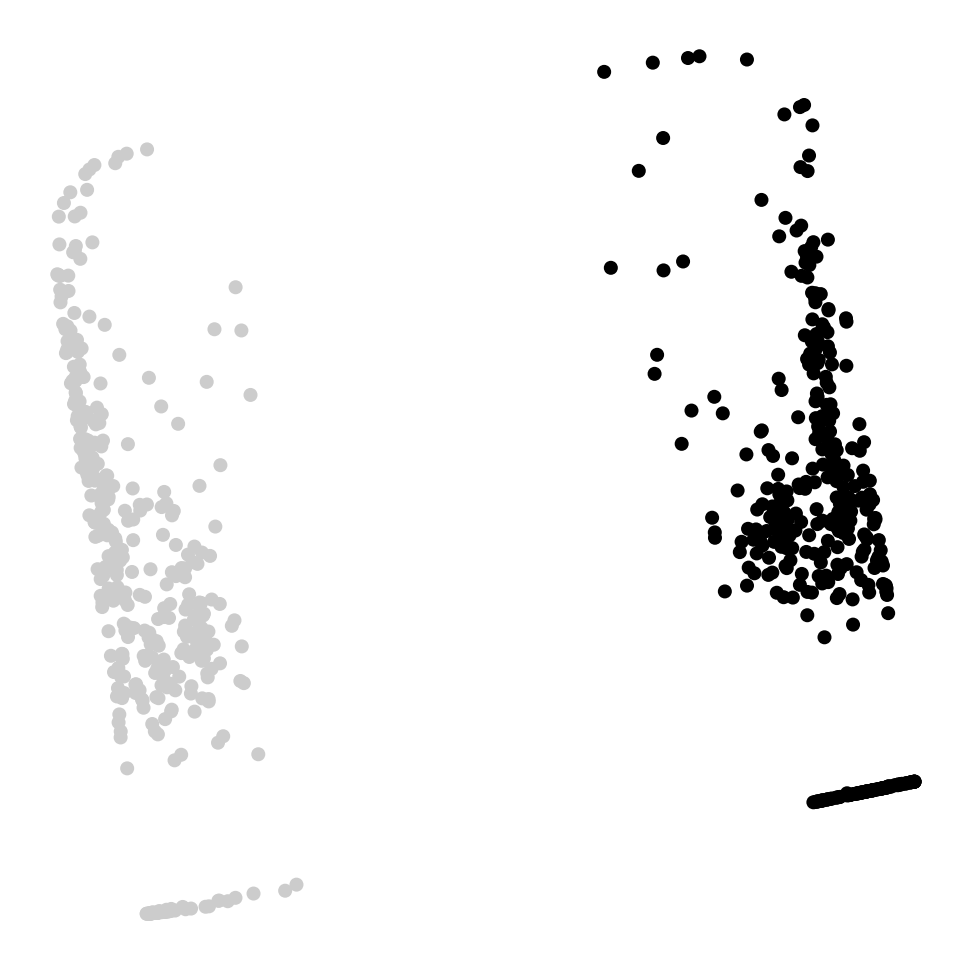

In [32]:
fig, ax = plt.subplots(figsize=(7,7))

x = adata.obsm["X_pca"][:,0]
y = adata.obsm["X_pca"][:,1]
c = adata.obs["plate"].astype("category").cat.codes.astype(int)

ax.scatter(x, y, c = c, cmap='nipy_spectral')

ax.set_axis_off()

plt.tight_layout()
plt.show()

# Reproduce Octant figures

In [0]:
let = list(string.ascii_uppercase[:string.ascii_uppercase.index("Q")])
num = np.arange(24)

plate = np.zeros((len(let), len(num)))

### Total amplicon counts

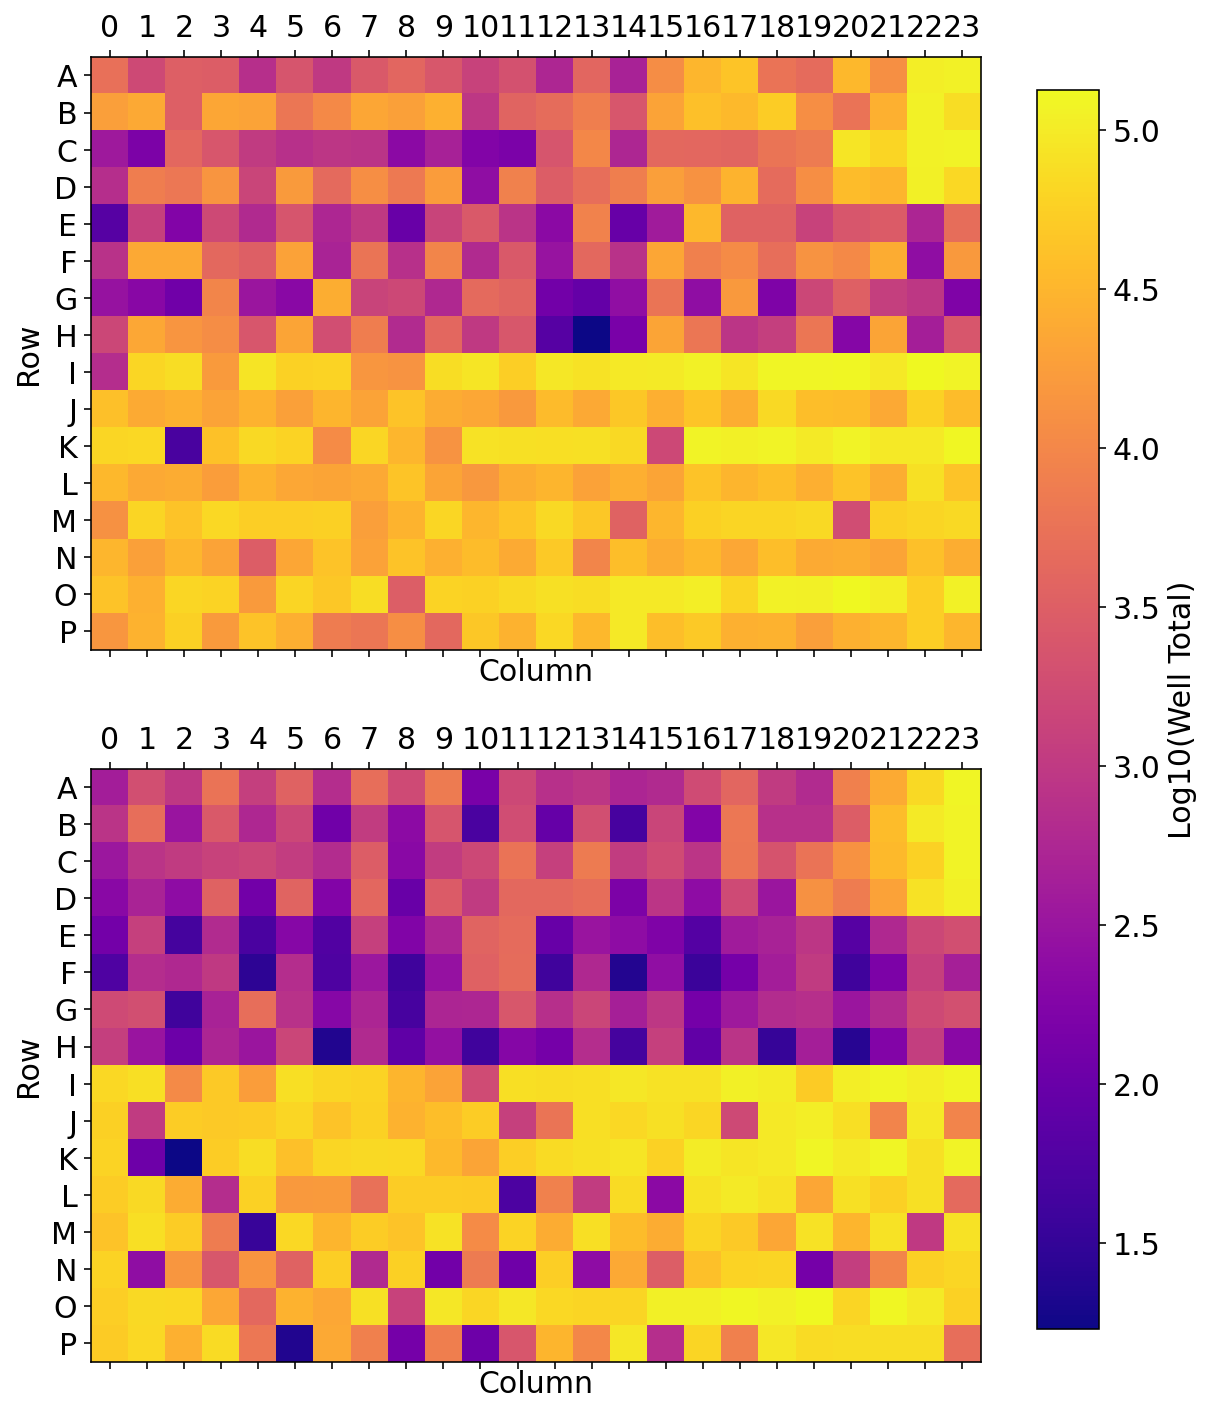

In [34]:
fig, axs = plt.subplots(figsize=(10,12), nrows=2)


# Plate 1
ax = axs[0]
mtx = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].layers["raw"].sum(axis=1)).reshape(16, 24)
cax = ax.matshow(np.log10(mtx), origin="upper", cmap="plasma")
#cbar = fig.colorbar(cax, label="Log10(Well Total)")

ax.set_xticks(np.arange(len(num)))
ax.set_xticklabels(num)
ax.set_yticks(np.arange(len(let)))
ax.set_yticklabels(let)

ax.set_xlabel("Column")
ax.set_ylabel("Row")

# Plate 2
ax = axs[1]
mtx = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].layers["raw"].sum(axis=1)).reshape(16, 24)
cax = ax.matshow(np.log10(mtx), origin="upper", cmap="plasma")
#cbar = fig.colorbar(cax, label="Log10(Well Total)")

ax.set_xticks(np.arange(len(num)))
ax.set_xticklabels(num)
ax.set_yticks(np.arange(len(let)))
ax.set_yticklabels(let)

ax.set_xlabel("Column")
ax.set_ylabel("Row")

cbar = fig.colorbar(cax, ax=axs.ravel().tolist(), shrink=0.95, label="Log10(Well Total)")

plt.show()

# Lysate

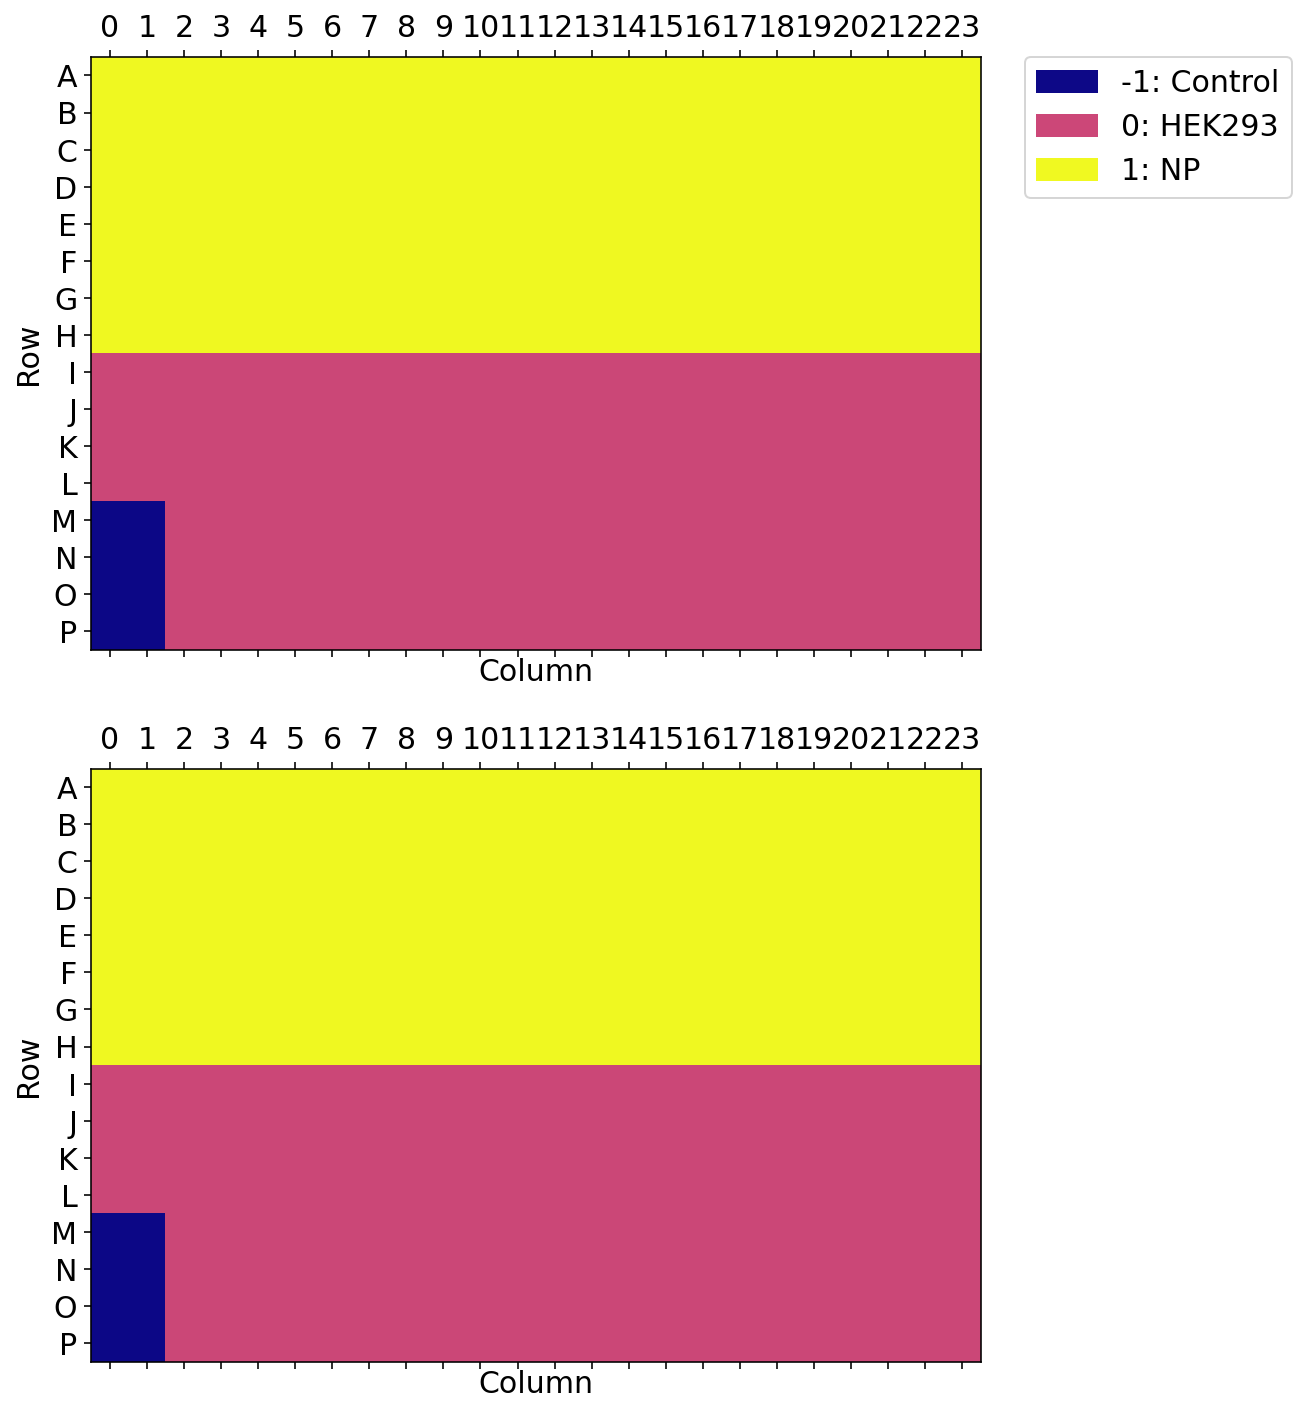

In [35]:
fig, axs = plt.subplots(figsize=(10,12), nrows=2)

# Plate 1
ax = axs[0]
mtx = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].obs["lysate"].astype("category").cat.codes).reshape(16, 24)
cax = ax.matshow(mtx, origin="upper", cmap="plasma")
#cbar = fig.colorbar(cax, label="Log10(Well Total)")

ax.set_xticks(np.arange(len(num)))
ax.set_xticklabels(num)
ax.set_yticks(np.arange(len(let)))
ax.set_yticklabels(let)

ax.set_xlabel("Column")
ax.set_ylabel("Row")

values = np.unique(mtx.ravel())
names = ["Control", "HEK293", "NP"]
colors = [ cax.cmap(cax.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{}: {}".format(values[i], names[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

# Plate 2
ax = axs[1]
mtx = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].obs["lysate"].astype("category").cat.codes).reshape(16, 24)
cax = ax.matshow(mtx, origin="upper", cmap="plasma")
#cbar = fig.colorbar(cax, label="Log10(Well Total)")

ax.set_xticks(np.arange(len(num)))
ax.set_xticklabels(num)
ax.set_yticks(np.arange(len(let)))
ax.set_yticklabels(let)

ax.set_xlabel("Column")
ax.set_ylabel("Row")



plt.show()

# Crossover

In [0]:
def plate_plot(mtx, ax):
    cax = ax.matshow(mtx, origin="upper", cmap="plasma")
    #cbar = fig.colorbar(cax, label="Log10(Well Total)")
    
    ax.set_xticks(np.arange(len(num)))
    ax.set_xticklabels(num)
    ax.set_yticks(np.arange(len(let)))
    ax.set_yticklabels(let)
    
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    return (cax, ax)

def plate_plot_empty(mtx, ax):
    cax = ax.matshow(mtx, origin="upper", cmap="plasma")
    #cbar = fig.colorbar(cax, label="Log10(Well Total)")
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    return (cax, ax)

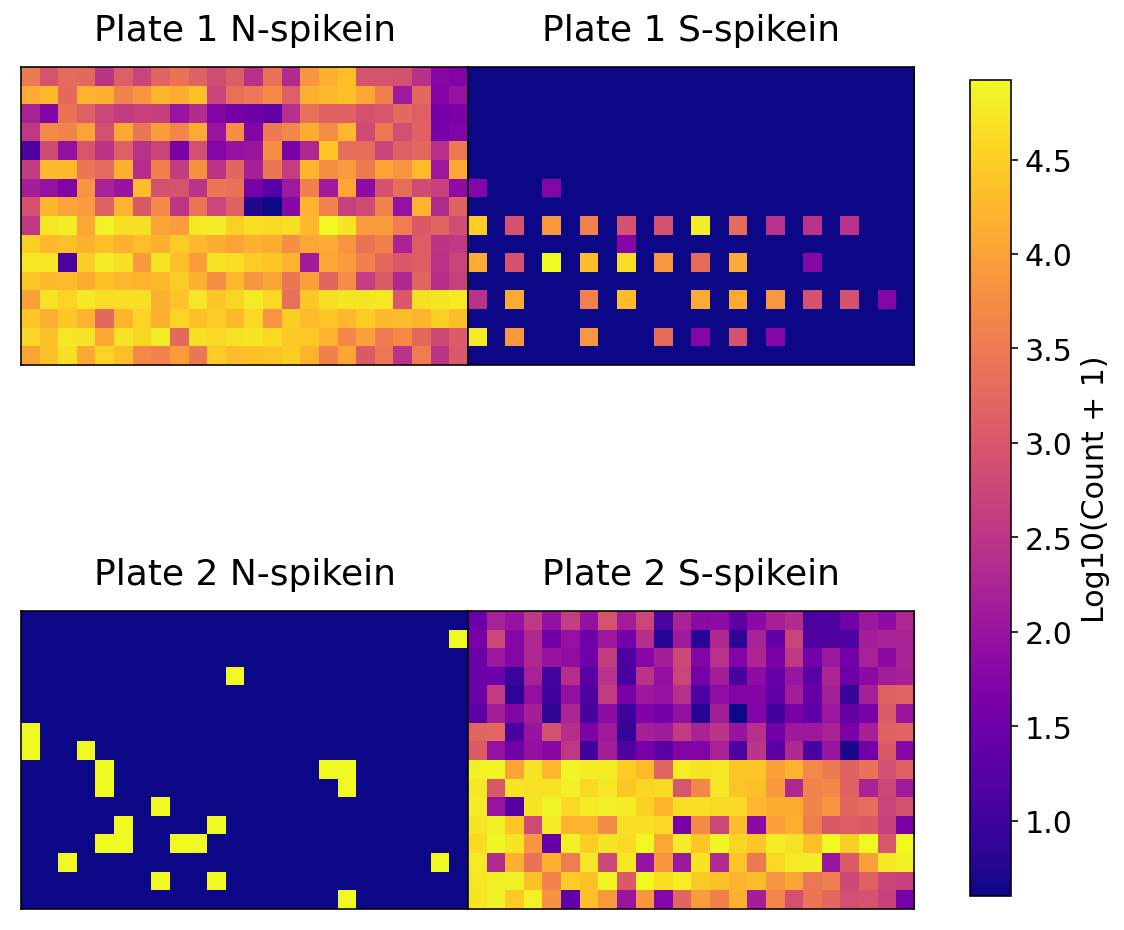

In [37]:
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0, hspace=0)

# Plate 1 N spike
ax = axs[0,0]
mtx = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].layers["raw"][:,adata.var.gene == "SARS-CoV-2_N_spikein"]).reshape(16, 24)
plate_plot_empty(np.log10(mtx + 1), ax)
ax.set_title("Plate 1 N-spikein")

# Plate 1 S Spike
ax = axs[0,1]
mtx = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].layers["raw"][:,adata.var.gene == "SARS-CoV-2_S_spikein"]).reshape(16, 24)
plate_plot_empty(np.log10(mtx + 1), ax)
ax.set_title("Plate 1 S-spikein")

# Plate 2 N Spike
ax = axs[1,0]
mtx = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].layers["raw"][:,adata.var.gene == "SARS-CoV-2_N_spikein"]).reshape(16, 24)
plate_plot_empty(np.log10(mtx + 1), ax)
ax.set_title("Plate 2 N-spikein")

# Plate 2 S Spike
ax = axs[1,1]
mtx = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].layers["raw"][:,adata.var.gene == "SARS-CoV-2_S_spikein"]).reshape(16, 24)
cax, ax = plate_plot_empty(np.log10(mtx + 1), ax)
ax.set_title("Plate 2 S-spikein")

#plt.tight_layout()
cbar = fig.colorbar(cax, ax=axs.ravel().tolist(), shrink=0.75, label="Log10(Count + 1)")

plt.show()

# Amount of Viral RNA per well

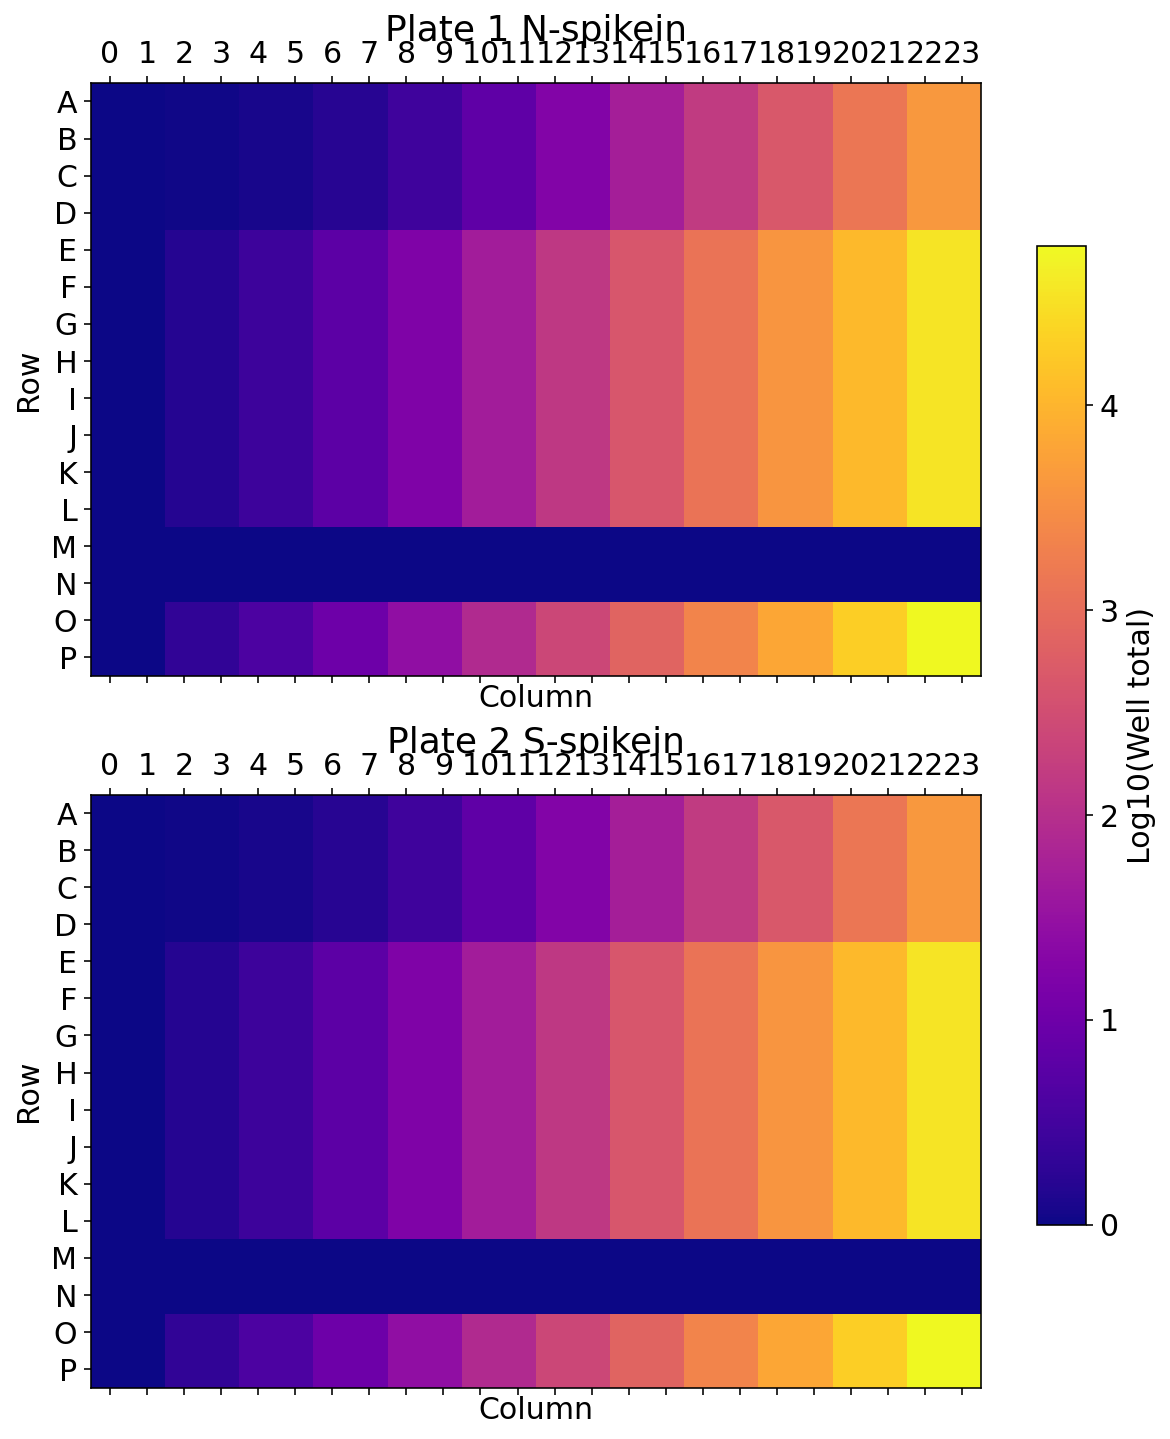

In [38]:
fig, axs = plt.subplots(figsize=(10,12), nrows=2)

# Plate 1
ax = axs[0]
mtx1 = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].obs["Twist"].values).reshape(16, 24)
mtx2 = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].obs["ATCC_RNA"].values).reshape(16, 24)
mtx3 = nd(adata[adata[adata.obs.plate=="Plate1"].obs.sort_values("well").index].obs["ATCC_viral"].values).reshape(16, 24)
mtx = mtx1+mtx2+mtx3
plate_plot(np.log10(mtx + 1), ax)
ax.set_title("Plate 1 N-spikein")

# PLate 2
ax = axs[1]
mtx1 = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].obs["Twist"].values).reshape(16, 24)
mtx2 = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].obs["ATCC_RNA"].values).reshape(16, 24)
mtx3 = nd(adata[adata[adata.obs.plate=="Plate2"].obs.sort_values("well").index].obs["ATCC_viral"].values).reshape(16, 24)
mtx = mtx1+mtx2+mtx3
cax, ax = plate_plot(np.log10(mtx + 1), ax)
ax.set_title("Plate 2 S-spikein")

cbar = fig.colorbar(cax, ax=axs.ravel().tolist(), shrink=0.75, label="Log10(Well total)")


plt.show()

# Limit of Detection

In [0]:
# HEK lysate only
data = adata[adata.obs.lysate=="HEK293"]

In [40]:
data

View of AnnData object with n_obs × n_vars = 368 × 5 
    obs: 'bcs', 'umi', 'ecs', 'cnt', 'plate', 'well', 'lysate', 'gene', 'Twist', 'ATCC_RNA', 'ATCC_viral'
    var: 'gene'
    uns: 'log1p'
    obsm: 'X_pca'
    layers: 'raw', 'norm', 'log1p', 'scale'

In [0]:
plate1 = data[data.obs["plate"] == "Plate1"]
plate2 = data[data.obs["plate"] == "Plate2"]

In [0]:
def lod(x, y, c=None, ax=ax):
    jittered_x = x + 0.1 * np.random.rand(len(x))
    ax.scatter(jittered_x, y, c= c, cmap="Reds")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax = yex(ax)
    return ax

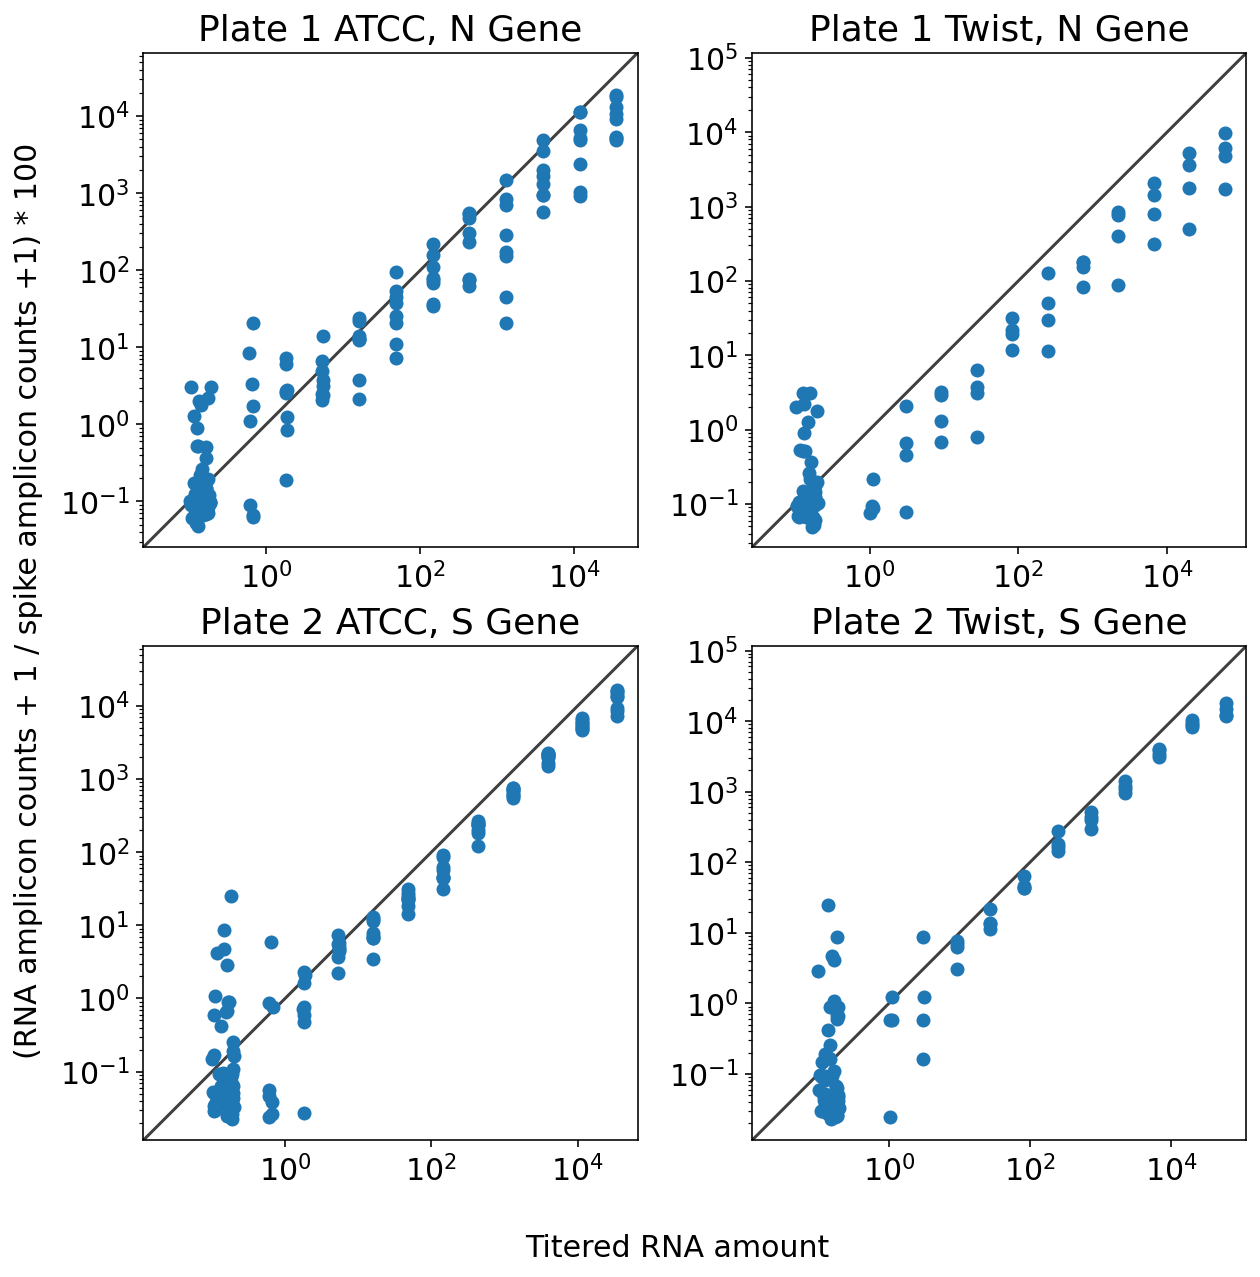

In [43]:
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
#fig.subplots_adjust(wspace=0, hspace=0)


plate = data[data.obs["plate"] == "Plate1"]
plate = plate[plate.obs.Twist.values==0]
# Plate 1 ATCC
ax = axs[0,0]
x = plate.obs.ATCC_RNA.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N_spikein"]+1)*100
lod(x, y, ax=ax)
ax.set_title("Plate 1 ATCC, N Gene")


# Plate 1 Twist
plate = data[data.obs["plate"] == "Plate1"]
plate = plate[plate.obs.ATCC_RNA.values==0]
ax = axs[0,1]
x = plate.obs.Twist.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N_spikein"]+1)*100
lod(x, y, ax=ax)
ax.set_title("Plate 1 Twist, N Gene")


plate = data[data.obs["plate"] == "Plate2"]
plate = plate[plate.obs.Twist.values==0]
# Plate 2 ATCC
ax = axs[1,0]
x = plate.obs.ATCC_RNA.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S_spikein"]+1)*100
lod(x, y, ax=ax)
ax.set_title("Plate 2 ATCC, S Gene")

# Plate 1 Twist
plate = data[data.obs["plate"] == "Plate2"]
plate = plate[plate.obs.ATCC_RNA.values==0]
ax = axs[1,1]
x = plate.obs.Twist.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S_spikein"]+1)*100
lod(x, y, ax=ax)
ax.set_title("Plate 2 Twist, S Gene")

    
fig.text(0.5, 0.05, 'Titered RNA amount', ha='center', va='center')
fig.text(0.05, 0.5, '(RNA amplicon counts + 1 / spike amplicon counts +1) * 100', ha='center', va='center', rotation='vertical')


plt.show()

## Don't divide by spikein

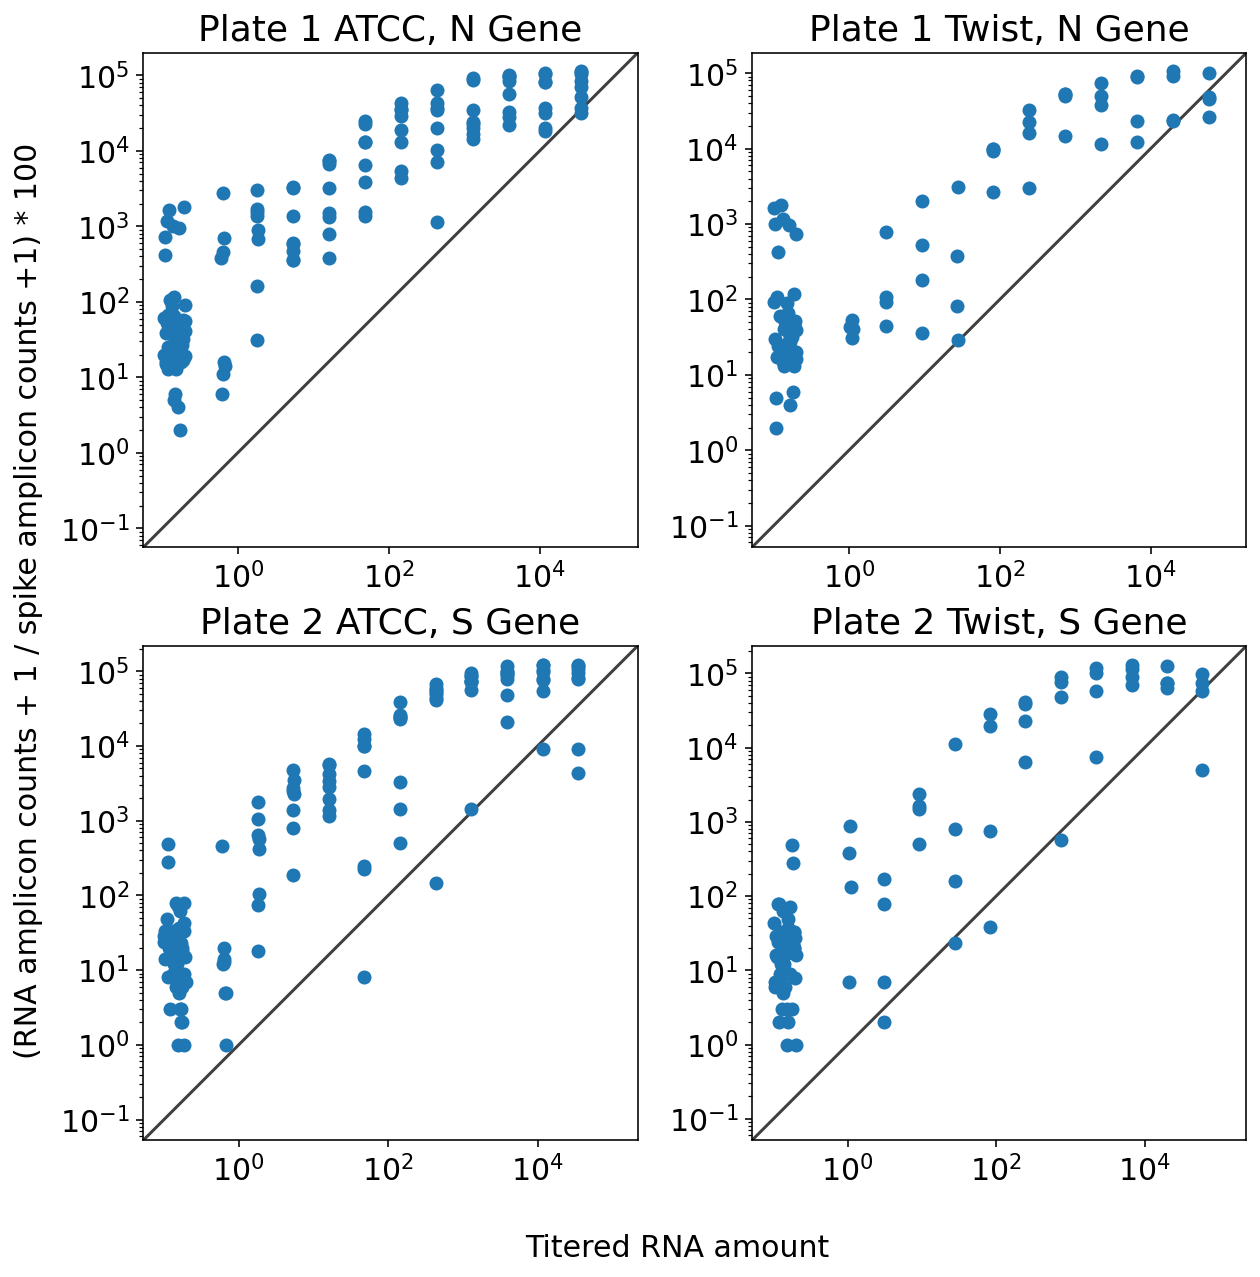

In [44]:
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
#fig.subplots_adjust(wspace=0, hspace=0)


plate = data[data.obs["plate"] == "Plate1"]
plate = plate[plate.obs.Twist.values==0]
# Plate 1 ATCC
ax = axs[0,0]
x = plate.obs.ATCC_RNA.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N"] + 1)
lod(x, y, ax=ax)
ax.set_title("Plate 1 ATCC, N Gene")


# Plate 1 Twist
plate = data[data.obs["plate"] == "Plate1"]
plate = plate[plate.obs.ATCC_RNA.values==0]
ax = axs[0,1]
x = plate.obs.Twist.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N"] + 1)
lod(x, y, ax=ax)
ax.set_title("Plate 1 Twist, N Gene")


plate = data[data.obs["plate"] == "Plate2"]
plate = plate[plate.obs.Twist.values==0]
# Plate 2 ATCC
ax = axs[1,0]
x = plate.obs.ATCC_RNA.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S"] + 1)
lod(x, y, ax=ax)
ax.set_title("Plate 2 ATCC, S Gene")

# Plate 1 Twist
plate = data[data.obs["plate"] == "Plate2"]
plate = plate[plate.obs.ATCC_RNA.values==0]
ax = axs[1,1]
x = plate.obs.Twist.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S"] + 1)
lod(x, y, ax=ax)
ax.set_title("Plate 2 Twist, S Gene")

    
fig.text(0.5, 0.05, 'Titered RNA amount', ha='center', va='center')
fig.text(0.05, 0.5, '(RNA amplicon counts + 1 / spike amplicon counts +1) * 100', ha='center', va='center', rotation='vertical')


plt.show()

# LoD with counts plotted

In [0]:
def lod_counts(x, y, c=None, ax=ax):
    jittered_x = x + 0.1 * np.random.rand(len(x))
    sc = ax.scatter(jittered_x, y, c= c, cmap="Reds")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax = yex(ax)
    return (sc, ax)

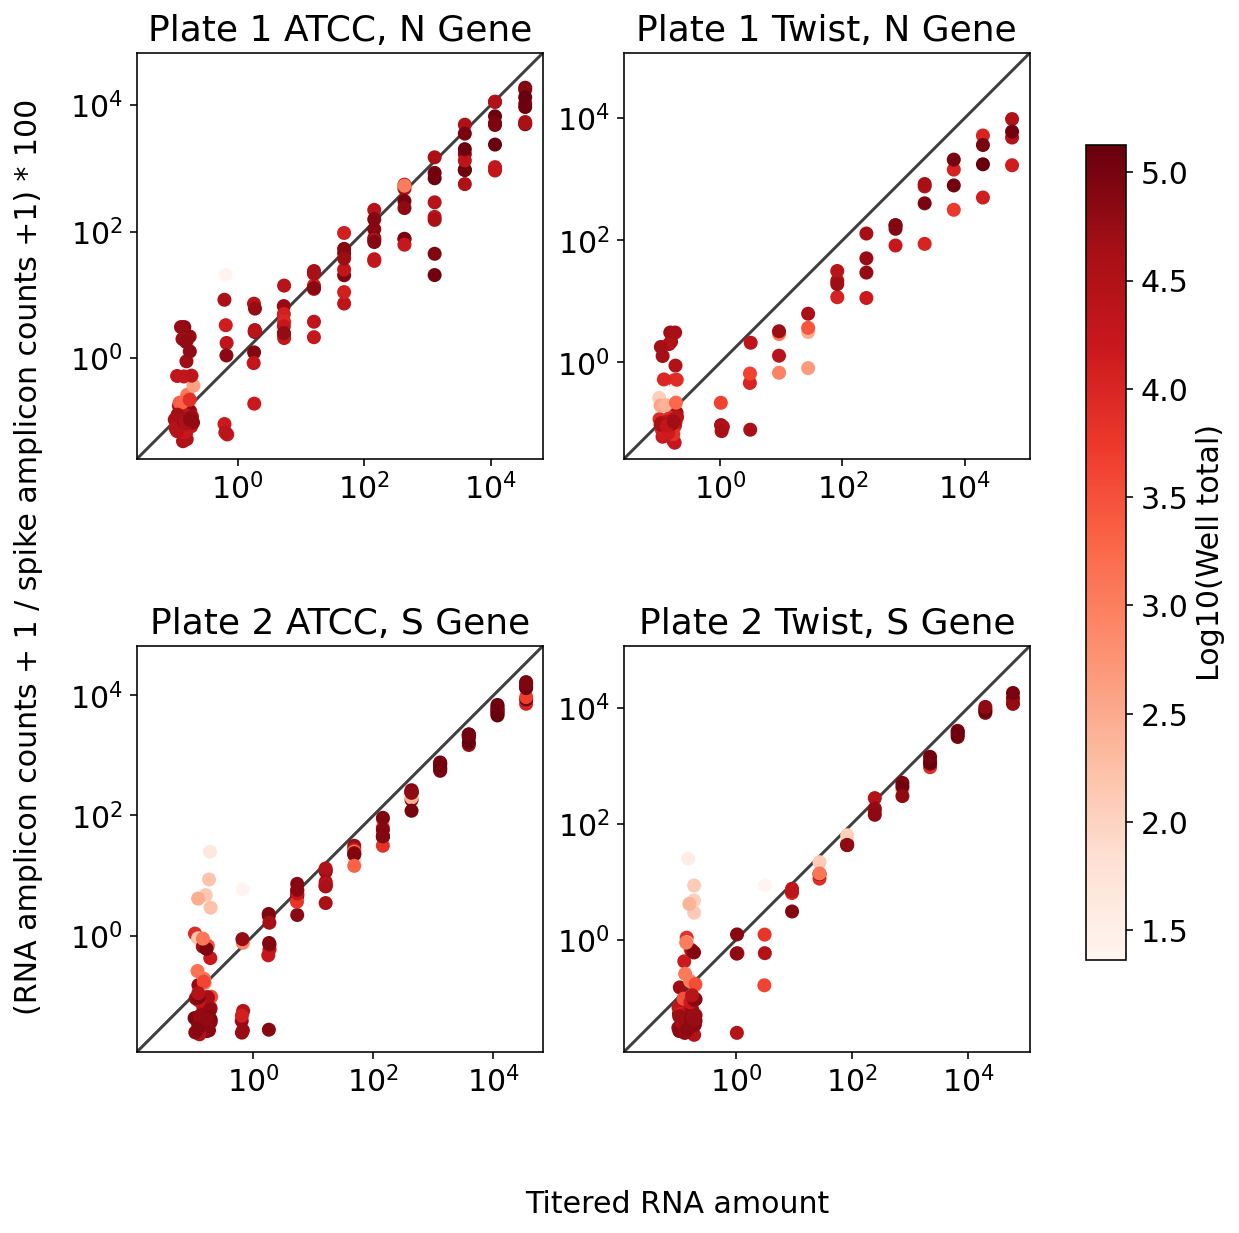

In [46]:
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
#fig.subplots_adjust(wspace=0, hspace=0)


plate = data[data.obs["plate"] == "Plate1"]
plate = plate[plate.obs.Twist.values==0]
# Plate 1 ATCC
ax = axs[0,0]
x = plate.obs.ATCC_RNA.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N_spikein"]+1)*100
c = np.log10(nd(plate.layers["raw"].sum(axis=1)) )
lod(x, y, c, ax)
ax.set_title("Plate 1 ATCC, N Gene")


# Plate 1 Twist
plate = data[data.obs["plate"] == "Plate1"]
plate = plate[plate.obs.ATCC_RNA.values==0]
ax = axs[0,1]
x = plate.obs.Twist.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_N_spikein"]+1)*100
c = np.log10(nd(plate.layers["raw"].sum(axis=1)) )
lod(x, y, c, ax)
ax.set_title("Plate 1 Twist, N Gene")


plate = data[data.obs["plate"] == "Plate2"]
plate = plate[plate.obs.Twist.values==0]
# Plate 2 ATCC
ax = axs[1,0]
x = plate.obs.ATCC_RNA.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S_spikein"]+1)*100
c = np.log10(nd(plate.layers["raw"].sum(axis=1)) )
lod(x, y, c, ax)
ax.set_title("Plate 2 ATCC, S Gene")

# Plate 1 Twist
plate = data[data.obs["plate"] == "Plate2"]
plate = plate[plate.obs.ATCC_RNA.values==0]
ax = axs[1,1]
x = plate.obs.Twist.values.copy()
x[x==0] = 0.1
y = (plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S"] + 1)/(plate.layers["raw"][:,plate.var.gene == "SARS-CoV-2_S_spikein"]+1)*100
c = np.log10(nd(plate.layers["raw"].sum(axis=1)) )
sc, ax = lod_counts(x, y, c, ax)
ax.set_title("Plate 2 Twist, S Gene")


fig.text(0.5, 0.05, 'Titered RNA amount', ha='center', va='center')
fig.text(0.05, 0.5, '(RNA amplicon counts + 1 / spike amplicon counts +1) * 100', ha='center', va='center', rotation='vertical')

cbar = fig.colorbar(sc, ax=axs.ravel().tolist(), shrink=0.75, label="Log10(Well total)")


plt.show()

In [47]:
print("This notebook to {:,.2f} min to run".format((time.time() - t0)/60))

This notebook to 5.33 min to run
